<a href="https://colab.research.google.com/github/Akhil-Tony/Covid19_Analysis/blob/main/covid19_next30day_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Data

dataset1 
https://www.kaggle.com/andradaolteanu/country-mapping-iso-continent-region/download

dataset2 
https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university/download

In [ ]:
from fbprophet import Prophet
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score
import os

In [ ]:
plt.style.use('ggplot')

In [ ]:
def get_file():
  upload_f=files.upload()
  filename=list(upload_f.keys())[0]
  data=pd.read_csv(io.BytesIO(upload_f[filename]))
  return data

In [ ]:
df0=get_file() #CONVENIENT_global_confirmed_cases.csv
df1=get_file() #CONVENIENT_global_deaths.csv

Saving CONVENIENT_global_confirmed_cases.csv to CONVENIENT_global_confirmed_cases.csv


Saving CONVENIENT_global_deaths.csv to CONVENIENT_global_deaths.csv


Data Preparation

In [ ]:
world = pd.DataFrame({'Country':[],'Cases':[],}) 
world['Country']=df0.columns[1:]
cases=[]
for i in world['Country']:
  cases.append(pd.to_numeric(df0[i][1:]).sum())

world['Cases']=cases

country_list=list(world['Country'].values)
idx=0
for i in country_list:
  sayac = 0
  for j in i:
    if j=='.':
      i = i[:sayac]
      country_list[idx]=i
    elif j=='(':
      i=i[:sayac-1]
      country_list[idx]=i
    else:
      sayac +=1
  idx+=1
world['Country']=country_list  
world=world.groupby('Country').sum().reset_index()       

In [ ]:
continent=get_file() #continents2.csv
continent['name']=continent['name'].str.upper()

Saving continents2.csv to continents2.csv


Data Visualization

In [ ]:
world['Cases Range']=pd.cut(world['Cases'],[-150000,50000,200000,800000,1500000,15000000]
                            ,labels=['U50K','50Kto200K','200Kto800K','800Kto1.5M','1.5M+'])
alpha = []
for i in world['Country'].str.upper().values:
  if i == 'BRUNEI':
    i = 'BRUNEI DARUSSALAM'
  elif i == 'US':
    i = 'UNITED STATES'
  if len(continent[continent['name']==i]['alpha-3'].values)==0:
    alpha.append(np.nan)    
  else:
    alpha.append(continent[continent['name']==i]['alpha-3'].values[0])  
world['Alpha3']=alpha    

In [ ]:
fig = px.choropleth(world.dropna(),locations='Alpha3',
                    color='Cases Range',projection='mercator',) 
#,color_discrete_sequence=['white','khaki','yellow','orange','red']
# fig.update_geos(fitbounds='locations',visible=False)
fig.update_layout(margin={'r':0,'t':0,'l':0,'b':0})
fig.show()

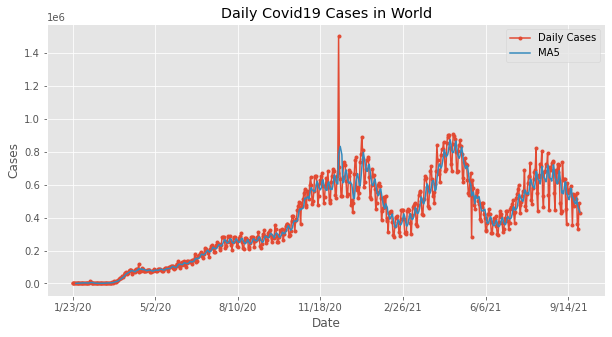

In [ ]:
# daily cases

count = []
for i in range(1,len(df0)):
  count.append(sum(pd.to_numeric(df0.iloc[i,1:].values)))
df = pd.DataFrame()
df['Date']=df0['Country/Region'][1:]
df['Cases']=count
df=df.set_index('Date')

count=[]
for i in range(1,len(df1)):
  count.append(sum(pd.to_numeric(df1.iloc[i,1:].values)))

df['Deaths'] = count

df['Cases'].plot(title='Daily Covid19 Cases in World',marker='.',figsize=(10,5),
                 label='Daily Cases')
df.Cases.rolling(window=5).mean().plot(figsize=(10,5),label='MA5')
plt.ylabel('Cases')
plt.legend()
plt.show()

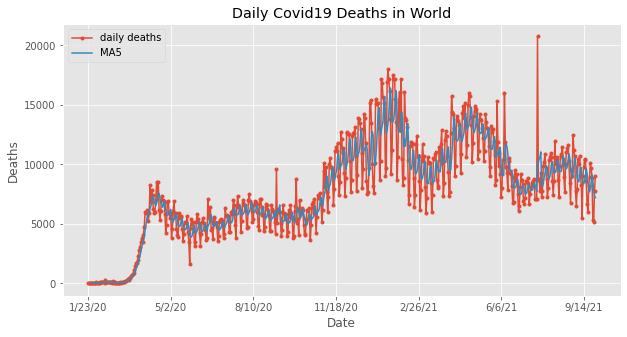

In [ ]:
df.Deaths.plot(title='Daily Covid19 Deaths in World',marker='.',label='daily deaths')
df.Deaths.rolling(window=5).mean().plot(figsize=(10,5),label='MA5')
plt.ylabel('Deaths')
plt.legend()
plt.show()

Covid19 Cases Prediction for Next 30 Days

In [ ]:
class Fbprophet(object):
  def fit(self,data):
    self.data = data
    self.model=Prophet(weekly_seasonality=True,daily_seasonality=False,
                       yearly_seasonality=False)
    self.model.fit(self.data)

  def forecast(self,periods,freq):
    self.future=self.model.make_future_dataframe(periods=periods,freq=freq)
    self.df_forecast = self.model.predict(self.future)

  def plot(self,xlabel='years',ylabel='values'):

    self.model.plot(self.df_forecast,xlabel=xlabel,ylabel=ylabel,figsize=(9,4))
    self.model.plot_components(self.df_forecast,figsize=(9,6))
  def R2(self):
    return r2_score(self.data.y,self.df_forecast.yhat[:len(df)])          

0.7950688978926186


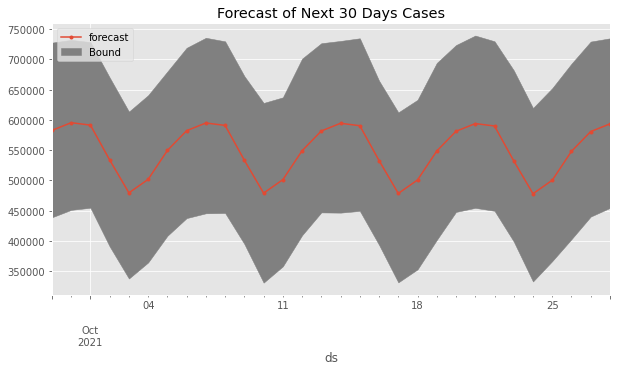

In [ ]:
df_fb = pd.DataFrame({'ds':[],'y':[]})
df_fb['ds'] = pd.to_datetime(df.index)
df_fb['y'] = df.iloc[:,0].values

model = Fbprophet()
model.fit(df_fb)
model.forecast(30,'D')
print(model.R2())

forecast = model.df_forecast[['ds','yhat_lower','yhat_upper','yhat']].tail(30).reset_index().set_index('ds').drop('index',axis=1)
forecast['yhat'].plot(marker='.',figsize=(10,5))
plt.fill_between(x=forecast.index,y1=forecast['yhat_lower'],y2=forecast['yhat_upper'],color='grey')
plt.legend(['forecast','Bound'],loc='upper left')
plt.title('Forecast of Next 30 Days Cases')
plt.show()

In [ ]:
df_india=pd.DataFrame()
df_india['Cases']=pd.to_numeric(df0['India'][1:])
df_india['Date']=df0['Country/Region'][1:]
df_india['Deaths']=pd.to_numeric(df1['India'][1:])
df_india=df_india.set_index('Date')

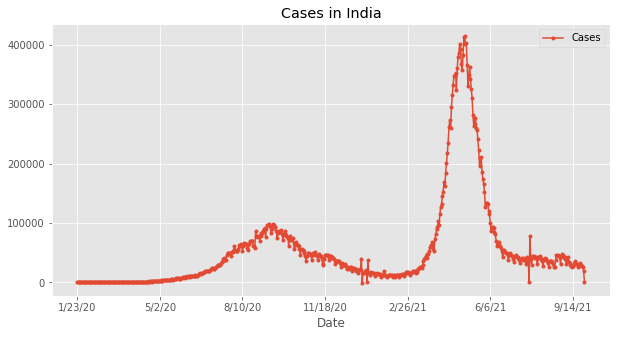

In [ ]:
df_india['Cases'].plot(marker='.',figsize=(10,5))
plt.title('Cases in India')
plt.legend()
plt.show()

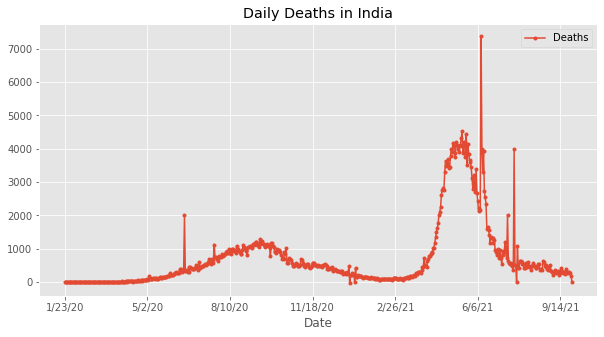

In [ ]:
df_india['Deaths'].plot(marker='.',figsize=(10,5))
plt.title('Daily Deaths in India')
plt.legend()
plt.show()

In [ ]:
df_india_f = pd.DataFrame()
df_india_f['ds'] = pd.to_datetime(df_india.index)
df_india_f['y'] = df_india.iloc[:,0].values

In [ ]:
model2 = Fbprophet()
model2.fit(df_india_f)
model2.forecast(30,'D')
model2.R2()

0.45097163349661074

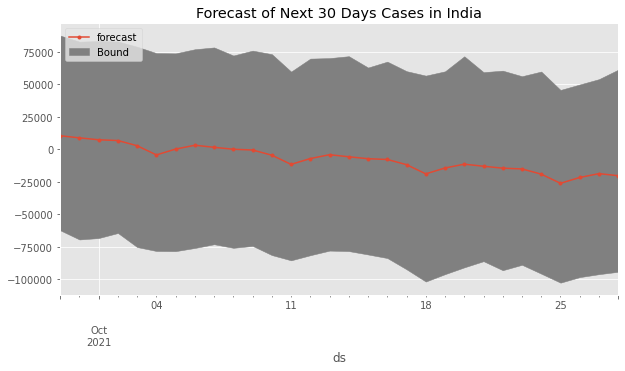

In [ ]:
forecast = model2.df_forecast[['ds','yhat_lower','yhat_upper','yhat']].tail(30).reset_index().set_index('ds').drop('index',axis=1)
forecast['yhat'].plot(marker='.',figsize=(10,5))
plt.fill_between(x=forecast.index,y1=forecast['yhat_lower'],y2=forecast['yhat_upper'],color='grey')
plt.legend(['forecast','Bound'],loc='upper left')
plt.title('Forecast of Next 30 Days Cases in India')
plt.show()

In [60]:
df_india.tail()

,Cases,Deaths
Date,,
9/24/21,29616.0,290.0
9/25/21,28326.0,260.0
9/26/21,26041.0,276.0
9/27/21,18795.0,179.0
9/28/21,0.0,0.0
